## Tranfer Learning with MobileNetV2

Welcome to the assignment, where you'll be using *transfer learning* on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

By the end of this assignment, you'll be able to:
- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pre-trained model to a new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy


### 1 - Packages


In [1]:
import matplotlib.pyplot as plt
import json 
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2026-01-09 09:14:51.994228: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 1.1 Create the Dataset and split it into Training and Validation Sets

When training and evaluating a deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call the `image_dataset_from_directory` to read from the directory and create both training and validation datasets.

If you are specifying a validation split, you'll also need to specify the `subset` argument. Just set the training set to `"subset='training'"` and the validation set to `"subset='validation'"`. 

You'll also set your seeds to match each other, so your training and validation sets don't overlap.


In [ ]:
os.chdir(os.path.join(os.getcwd(), 'Chapter04-Convolutional-Neural-Networks',
                       'DeepConvolutional_Models-CaseStudies', 
                       'W2A2'))

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = 'dataset/'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size = BATCH_SIZE,
                                            image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                    subset="validation",
                                                    seed=42,
                                                    batch_size = BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


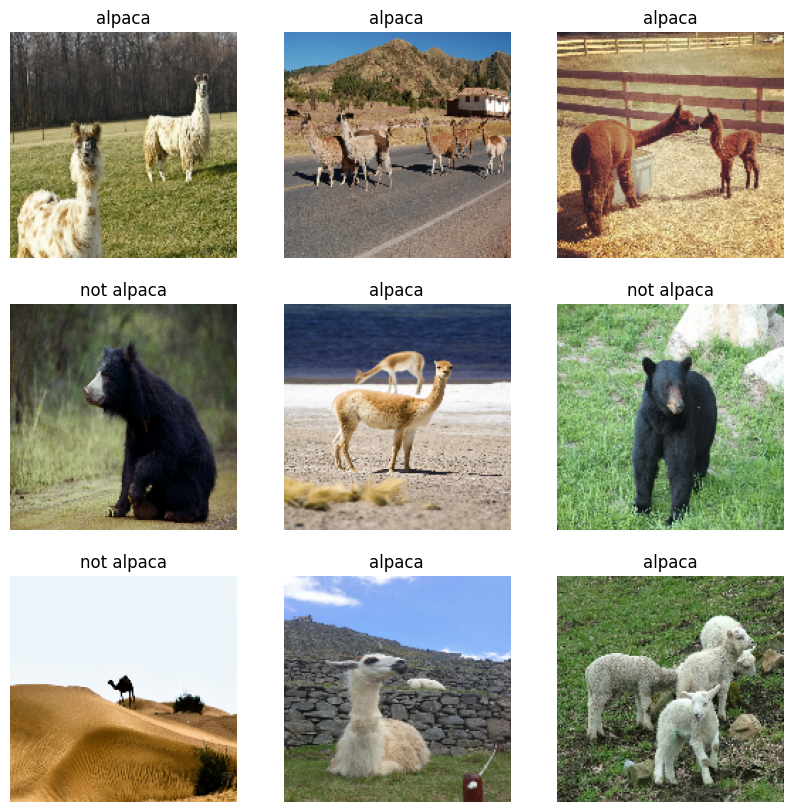

In [8]:
## Now let's take a look at the images from the training dataset
## Note: The original dataset has some mislabelled images in it as well

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2-Preprocess and Augment the Training Data

You may have encounted the `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in a data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically.  Autotune prompts tf.data to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm.The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them.  Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later. Ahh, so convenient!

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### E1 - data_augmenter
Implement a function for data augmentation. Use a Sequential keras model composed of 2 layers:
- RandomFlip('horizontal')
- RandomRotation(0.2)

In [11]:
## UNQ_C1
## GRADED FUNCTION: data_augmenter

def data_augmenter():
    """ 
    Create a Sequential model composed of 2 layers:
    Returns a Sequential model that performs data augmentation."""

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))  
    
    return data_augmentation


In [12]:
augmenter = data_augmenter()
assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


Take a look at how an image from the training set has been augmented with simple transformations:
From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from!


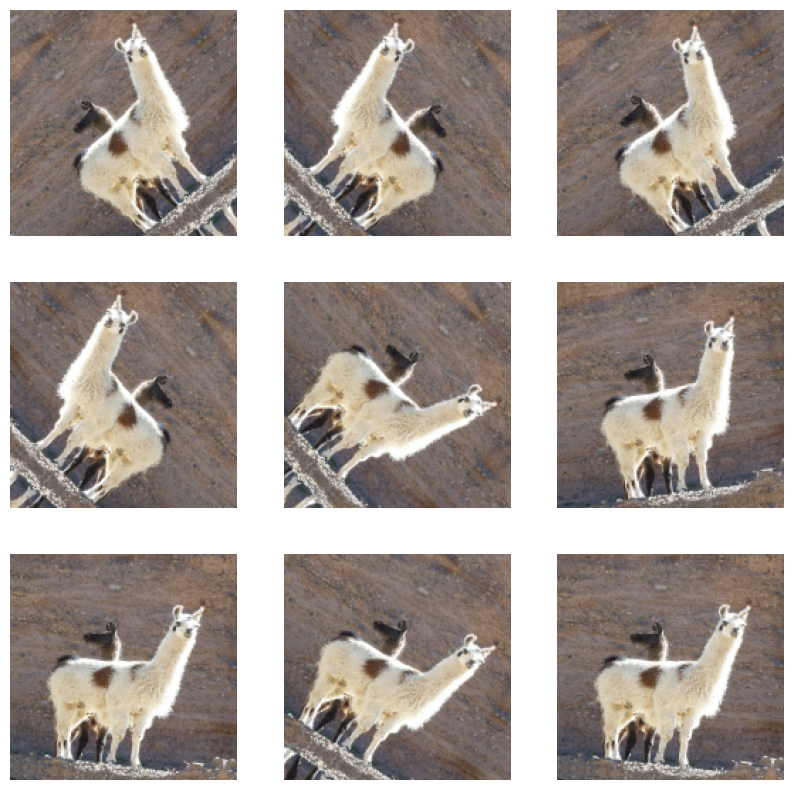

In [17]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), 
            training=True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")
    

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [18]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 
